# Downstream Implications of Methodological Choices

### Python and R

This section is just some standard imports for python + R notebooks, you can skip reading it.

In [1]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# show all columns on pandas dataframes
pd.set_option('display.max_columns', None)


In [2]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%%R

# My commonly used R imports

require('tidyverse')


R[write to console]: Loading required package: tidyverse



── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.1.4      ✔ stringr 1.4.0 
✔ readr   2.1.3      ✔ forcats 0.5.1 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Read the data



The cell below loads the data in python:

In [4]:
df = pd.read_csv('raw-polls.csv')

The cell below loads the same data in R:

In [5]:
%%R

df <- read_csv('raw-polls.csv') %>% filter(type_simple != 'Pres-P')

Rows: 10776 Columns: 31
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): race, location, type_simple, type_detail, pollster, methodology, p...
dbl (17): poll_id, question_id, race_id, year, pollster_rating_id, samplesiz...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Analysis

<img src="images/construct-measurement.png"  width="400">

### construct
Accuracy of pollster

### Measurement
- ours
    - `avg_bias`  - defined as the mean of the bias for all polls conducted by a pollster
    - `avg_error` - defined as the mean of the absolute value of bias for all polls conducted by a pollster
- FiveThirtyEight's
    - `predictive_plus_minus` - FiveThirtyEight's fancy metric
defined here: https://fivethirtyeight.com/features/how-fivethirtyeight-calculates-pollster-ratings/

In [6]:
df['error'] = df.bias.abs()

<hr>

Let's compare the two metrics

In [7]:
pollster_ratings_df = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/pollster-ratings/pollster-ratings.csv')
ratings_df = pollster_ratings_df[['Pollster Rating ID', 'Pollster', 'Rank', '538 Grade', 'Predictive Plus-Minus']]
ratings_df.columns = ['pollster_rating_id', 'pollster', 'rank_538', 'grade_538', 'predictive_plus_minus_538']
ratings_df.head()

,pollster_rating_id,pollster,rank_538,grade_538,predictive_plus_minus_538
0,304,Selzer & Co.,1,A+,-1.164872
1,3,ABC News/The Washington Post,2,A+,-0.991960
2,448,Siena College/The New York Times Upshot,3,A+,-0.954452
3,144,IBD/TIPP,4,A+,-0.938424
4,94,Field Research Corp. (Field Poll),5,A/B,-0.906695


In [8]:
df = df.merge(ratings_df, on='pollster_rating_id', suffixes=('','_538'))
df.head(1)

,poll_id,question_id,race_id,year,race,location,type_simple,type_detail,pollster,pollster_rating_id,methodology,partisan,polldate,samplesize,cand1_name,cand1_id,cand1_party,cand1_pct,cand2_name,cand2_id,cand2_party,cand2_pct,cand3_pct,margin_poll,electiondate,cand1_actual,cand2_actual,margin_actual,bias,rightcall,comment,error,pollster_538,rank_538,grade_538,predictive_plus_minus_538
0,26013,87909,1455,1998,1998_Gov-G_NY,NY,Gov-G,Gov-G,Blum & Weprin Associates,32,Live Phone,NaN,10/13/98,364.0,Peter Vallone,13080,DEM,26.0,George Pataki,13083,REP,57.0,9.0,-31.0,11/3/98,33.16,54.32,-21.15,-9.85,1.0,for New York Daily News | WABC-TV (New York),9.85,Blum & Weprin Associates,19,A/B,-0.537081


In [60]:
piv_bias = df \
    .pivot_table(index=['pollster_rating_id', 'pollster', 'grade_538', 'rank_538', 'predictive_plus_minus_538'], 
                 values='bias', 
                 aggfunc=['mean', 'median', 'std', 'count']) 

piv_bias.head(3)

,,,,,mean,median,std,count
,,,,,bias,bias,bias,bias
pollster_rating_id,pollster,grade_538,rank_538,predictive_plus_minus_538,,,,
1,20/20 Insight,B/C,383,0.772671,2.938000,2.13,3.211880,5
2,A&A Research,B/C,331,0.678953,-10.040000,-10.04,NaN,1
3,ABC News/The Washington Post,A+,2,-0.991960,1.256234,0.99,3.804725,77


In [61]:
# look at mean, median, std, and count of error
piv_error = df \
    .pivot_table(index=['pollster_rating_id', 'pollster', 'grade_538', 'rank_538', 'predictive_plus_minus_538'], 
                 values='error', 
                 aggfunc=['mean', 'median', 'std', 'count']) 

piv_error.head(3)

,,,,,mean,median,std,count
,,,,,error,error,error,error
pollster_rating_id,pollster,grade_538,rank_538,predictive_plus_minus_538,,,,
1,20/20 Insight,B/C,383,0.772671,3.498000,2.13,2.410595,5
2,A&A Research,B/C,331,0.678953,10.040000,10.04,NaN,1
3,ABC News/The Washington Post,A+,2,-0.991960,2.977273,2.51,2.663462,77


In [63]:
# merge 538 grades with bias and error
piv = piv_error.merge(piv_bias, left_index=True, right_index=True)
piv.columns = ['_'.join(col).strip() for col in piv.columns.values]
piv = piv.reset_index().set_index('pollster_rating_id')

piv.head(3)

,pollster,grade_538,rank_538,predictive_plus_minus_538,mean_error,median_error,std_error,count_error,mean_bias,median_bias,std_bias,count_bias
pollster_rating_id,,,,,,,,,,,,
1,20/20 Insight,B/C,383,0.772671,3.498000,2.13,2.410595,5,2.938000,2.13,3.211880,5
2,A&A Research,B/C,331,0.678953,10.040000,10.04,NaN,1,-10.040000,-10.04,NaN,1
3,ABC News/The Washington Post,A+,2,-0.991960,2.977273,2.51,2.663462,77,1.256234,0.99,3.804725,77


### Compare `mean_error` to `predictive_plus_minus_538`

Best Pollsters

In [76]:
piv.sort_values(by='mean_error').head(5)

,pollster,grade_538,rank_538,predictive_plus_minus_538,mean_error,median_error,std_error,count_error,mean_bias,median_bias,std_bias,count_bias
pollster_rating_id,,,,,,,,,,,,
386,Winthrop University,B/C,127,0.171106,0.18,0.18,NaN,1,0.18,0.18,NaN,1
556,Amber Integrated,B/C,207,0.499158,0.38,0.38,NaN,1,-0.38,-0.38,NaN,1
461,1892 Polling,B/C,219,0.519891,0.61,0.61,NaN,1,-0.61,-0.61,NaN,1
425,Ogden & Fry,B/C,150,0.300123,0.65,0.65,0.325269,2,-0.23,-0.23,0.919239,2
422,Mercyhurst University,B/C,240,0.553967,0.74,0.74,NaN,1,-0.74,-0.74,NaN,1


In [66]:
piv.sort_values(by='predictive_plus_minus_538').head(5)

,pollster,grade_538,rank_538,predictive_plus_minus_538,mean_error,median_error,std_error,count_error,mean_bias,median_bias,std_bias,count_bias
pollster_rating_id,,,,,,,,,,,,
304,Selzer & Co.,A+,1,-1.164872,2.854242,1.72,2.920936,33,0.202121,0.610,4.109869,33
3,ABC News/The Washington Post,A+,2,-0.991960,2.977273,2.51,2.663462,77,1.256234,0.990,3.804725,77
448,Siena College/The New York Times Upshot,A+,3,-0.954452,4.361951,4.07,3.166509,82,1.422927,1.515,5.219059,82
144,IBD/TIPP,A+,4,-0.938424,2.086129,2.20,1.535239,31,-1.589355,-2.200,2.060026,31
94,Field Research Corp. (Field Poll),A/B,5,-0.906695,3.792222,2.65,3.193255,18,-2.455556,-2.240,4.363407,18


Worst Pollsters

In [79]:
piv.sort_values(by='mean_error').tail(5)
# remove nulls - ask why

,pollster,grade_538,rank_538,predictive_plus_minus_538,mean_error,median_error,std_error,count_error,mean_bias,median_bias,std_bias,count_bias
pollster_rating_id,,,,,,,,,,,,
554,ROI Rocket,B/C,136,0.223429,NaN,NaN,NaN,0,NaN,NaN,NaN,0
561,OurProgress (The Progress Campaign),F,289,0.616165,NaN,NaN,NaN,0,NaN,NaN,NaN,0
579,Targeted Persuasion,B/C,233,0.538065,NaN,NaN,NaN,0,NaN,NaN,NaN,0
599,El Nuevo Día/The Research Office,B/C,167,0.354400,NaN,NaN,NaN,0,NaN,NaN,NaN,0
600,Jorge Benítez,B/C,272,0.602381,NaN,NaN,NaN,0,NaN,NaN,NaN,0


In [74]:
piv.sort_values(by='predictive_plus_minus_538').tail(5)

,pollster,grade_538,rank_538,predictive_plus_minus_538,mean_error,median_error,std_error,count_error,mean_bias,median_bias,std_bias,count_bias
pollster_rating_id,,,,,,,,,,,,
143,Humphrey Institute,C/D,489,1.941500,5.750000,5.725,3.439805,8,3.785000,4.480,5.765860,8
150,Indiana University-Purdue University Fort Wayne,C/D,490,2.048179,NaN,NaN,NaN,0,NaN,NaN,NaN,0
231,Nielson Brothers Polling,C/D,491,2.217821,12.262727,11.160,7.095249,11,12.262727,11.160,7.095249,11
157,Jayhawk Consulting Services,C/D,492,2.793560,37.615000,37.615,7.530687,2,37.615000,37.615,7.530687,2
101,Fort Hays State University,C/D,493,2.925767,18.730000,18.730,21.679894,2,-18.730000,-18.730,21.679894,2


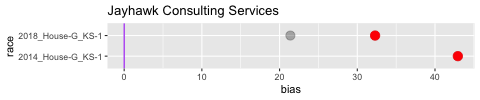

In [81]:
%%R -h 100

base_plot <- function(pollster_to_plot) {

    # filter to only polls from pollster_to_plot
    pollster_df <- df %>% filter(pollster==pollster_to_plot)

    # get a unique list of races where that pollster has polled
    only_races_this_pollster_has_polled <- pollster_df$race %>% unique()

    # get ALL polls from those races
    polls_from_races_this_pollster_has_polled <- df %>% 
        filter(race %in% only_races_this_pollster_has_polled)

    # plot them
    ggplot(polls_from_races_this_pollster_has_polled) +
        aes(x=bias, y=race) +
        geom_point(size=4, alpha=.3) +
        geom_point(data=pollster_df,size=4, alpha=1, color='red') +
        geom_vline(aes(xintercept=0), color="purple") +
        labs(title = pollster_to_plot)
}

base_plot('Jayhawk Consulting Services') 

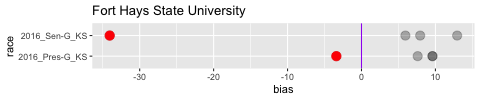

In [82]:
%%R -h 100

base_plot('Fort Hays State University') 

# Metric Comparison

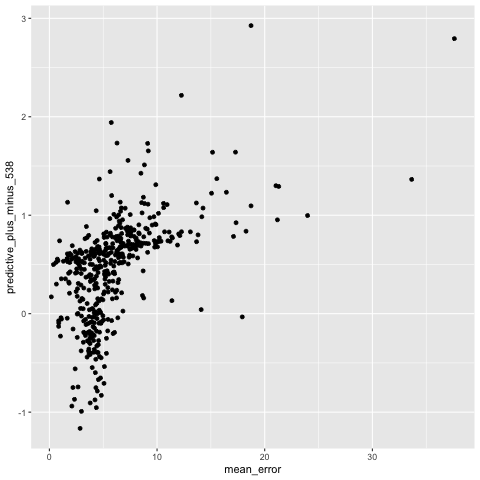

In [93]:
%%R ggplot -i piv

library(ggrepel)

ggplot(piv) +
    aes(x=mean_error, y=predictive_plus_minus_538, label=pollster) +
    geom_point() # +
#     geom_text_repel(data = piv %>% filter(mean_error > 10))